In [5]:
!pip install chromadb sentence-transformers torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.6 MB/s eta 

In [1]:
!pip install koreanize_matplotlib

  Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl.metadata (992 bytes)
Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl (7.9 MB)


In [ ]:
import os
import torch                            # PyTorch: 딥러닝 모델 구축 및 실행을 위한 핵심 라이브러리
from torchvision import transforms      # PyTorch의 비전(Vision) 라이브러리: 이미지 전처리 도구 제공
from PIL import Image                   # 이미지 파일(JPEG, PNG 등)을 다루기 위한 라이브러리
from chromadb import PersistentClient   # ChromaDB: 벡터 데이터베이스 클라이언트 (로컬 저장소 사용)
from torchvision.models import resnet18 # ResNet18: 이미지 특징 추출에 사용될 사전 학습된 CNN 모델
import torchvision.models as models     # torchvision.models 모듈을 models 별칭으로 임포트
import koreanize_matplotlib             # Matplotlib에서 한글 폰트 깨짐 현상을 해결
from google.colab import files          # Colab 환경에서 파일을 업로드할 때 사용
import matplotlib.pyplot as plt         # 시각화 라이브러리 (검색 결과를 이미지로 보여줄 때 사용)

# Colab 환경에서 이미지 파일을 업로드하는 명령어 (실행 환경 가정)
upload = files.upload()

Saving apple.jpeg to apple (1).jpeg
Saving grape.jpeg to grape (1).jpeg
Saving peach.jpeg to peach (1).jpeg


In [ ]:
# 1. 이미지를 벡터화(Embedding)할 ResNet18 모델 설정
model = resnet18(weights='ResNet18_Weights.DEFAULT')    # ImageNet 데이터셋으로 사전 학습된 ResNet18 모델을 불러옴 (Transfer Learning)
model.eval()    # 모델을 평가 모드로 전환 (Dropout/BatchNorm 고정)
# 핵심: 모델의 마지막 분류층(FC층)을 제거하여 512차원 특징 추출기(Feature Extractor)로 사용
model = torch.nn.Sequential(*list(model.children())[:-1])   # 맨 마지막 FC층은 제거(분류모델이 아니라 임베딩만 원함)
print(model)
# 2. 이미지를 불러와 512차원 벡터로 변환하는 함수
def image_to_vectorFunc(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224,224)),   # ResNet18 입력 이미지 크기(3, 224, 224)를 원함
        transforms.ToTensor()   #PIL.image를 torch.tensor로 변환  텐서 변환 및 0.0~1.0으로 정규화
    ])

    # 모델 입력 형태: (배치크기, 채널, 높이, 너비) = (1, 3, 224, 224)
    tensor = transform(image).unsqueeze(0) #모델에 넣기 위해 배치차원 (앞에 1) 추가 (3,224,224)
    with torch.no_grad():    # 역전파(기울기 계산) 비활성화 -> 추론 속도 향상 및 메모리 절약
        # 모델 실행 후 (1, 512, 1, 1) 형태의 출력을 512차원 벡터 (512,)로 압축
        vec = model(tensor).squeeze().numpy()   #(512,) 모든 크기의 1인 차원 제거
        # vec의 결과는 (1, 512, 1, 1) -> (512,)
    print(f'{img_path} -> 벡터(앞 10개): {vec[:10]}')
    return vec.tolist() # ChromaDB 저장을 위해 Numpy 배열을 파이썬 리스트로 변환

# 3. 벡터 DB 설정 및 이미지 파일 경로 정의
client = PersistentClient('./image_chroma2')    # 새로운 DB 경로 설정
collection = client.get_or_create_collection(name='images')
image_files = ['apple.jpeg', 'peach.jpeg', 'grape.jpeg']
ids = [f'img{i}' for i in range(len(image_files))]
print('ids :',ids)

# 4. 이미지 벡터화 및 DB 저장 (Indexing)
for img_id, img_path in zip(ids, image_files):
    if not os.path.exists(img_path):
        print(f'파일 없음 : {img_path}')
        continue
    vec = image_to_vectorFunc(img_path)
    collection.add(
        embeddings=[vec],
        documents=[img_path],
        ids=[img_id],
        metadatas=[{'filename': img_path}]
    )

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

id = img0
documents :  apple.jpeg
metadatas :  {'filename': 'apple.jpeg'}
embeddings 10개 :  [2.74511003 1.38714886 0.48933688 1.52329242 0.20173761 1.49299932
 0.51078451 0.9898755  0.7163552  0.24798128]
apple.jpeg -> 벡터(앞 10개): [2.74511    1.3871489  0.48933688 1.5232924  0.20173761 1.4929993
 0.5107845  0.9898755  0.7163552  0.24798128]
검색 이미지 : apple.jpeg
유사 이미지 :
-파일명 :apple.jpeg (유사도 거리 : 0.0000)
-파일명 :peach.jpeg (유사도 거리 : 394.2893)
-파일명 :grape.jpeg (유사도 거리 : 684.0030)


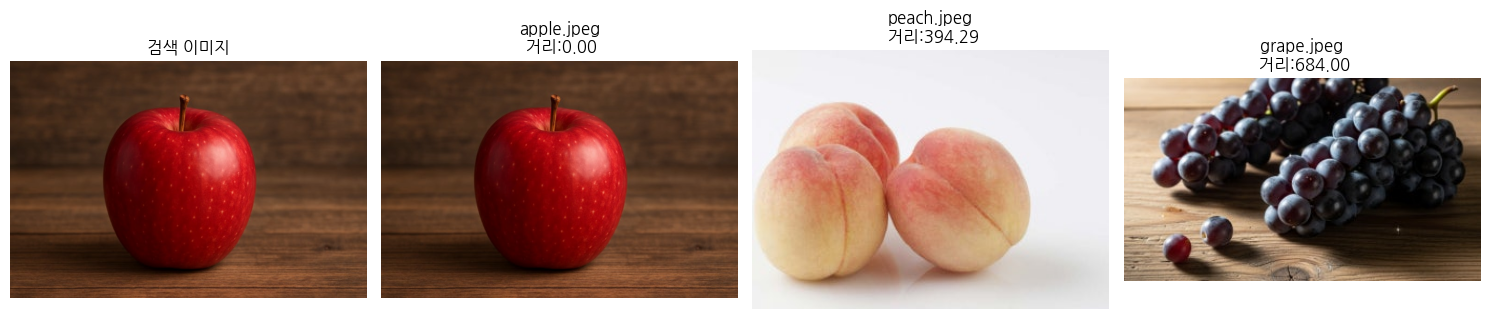

In [ ]:
# 저장된 벡터 일부 출력 (검증)
record = collection.get(ids = ['img0'], include=['embeddings','documents','metadatas'])
if len(record['documents']) > 0:
  print('id = img0')
  print('documents : ', record['documents'][0])
  print('metadatas : ', record['metadatas'][0])
  print('embeddings 10개 : ', record['embeddings'][0][:10])
else:
  print('img0에 해당하는 자료가 없어요')



# 5. 유사 이미지 검색 및 시각화 (Retrieval)
query_image_path = 'apple.jpeg'
if not os.path.exists(query_image_path):
    print(f'검색 이미지가 없어요 : {query_image_path}')
else:
    query_vec = image_to_vectorFunc(query_image_path)
    results = collection.query(
        query_embeddings=[query_vec],
        n_results=3,
        include=['metadatas', 'distances', 'documents']
    )

    print(f'검색 이미지 : {query_image_path}')
    print('유사 이미지 :')
    for doc, meta, dist in zip(results['documents'][0], results['metadatas'][0],results['distances'][0]):
        print(f'-파일명 :{meta['filename']} (유사도 거리 : {dist:.4f})')

    # 6. 시각화 함수 정의 및 실행
    def show_similiar_images(query_path, result_paths, distances):
        fig, axes = plt.subplots(1, len(result_paths) + 1, figsize=(15,5))
        # 검색 이미지
        query_img = Image.open(query_path)
        axes[0].imshow(query_img)
        axes[0].set_title('검색 이미지')
        axes[0].axis('off')
        # 결과 이미지들
        for i, (path, dist) in enumerate(zip(result_paths, distances)):
          if not os.path.exists(path): continue
          sim_img = Image.open(path)
          axes[i+1].imshow(sim_img)
          axes[i+1].set_title(f'{os.path.basename(path)}\n 거리:{dist:.2f}')
          axes[i+1].axis('off')

        plt.tight_layout()
        plt.show()

    result_paths = results['documents'][0]
    distances = results['distances'][0]
    show_similiar_images(query_image_path, result_paths, distances)
    # end of if

In [ ]:
# cosine similarity  계산
# 7. 코사인 유사도 직접 계산 (검증)
import numpy as np
from numpy.linalg import norm
# 코사인 유사도 공식 정의 (벡터 내적 / 벡터 크기 곱)
def cosine_similarityFunc(vec1, vec2):
    return np.dot(vec1, vec2)/(norm(vec1)*norm(vec2))

query_vec = image_to_vectorFunc(query_image_path)
results = collection.query(
  query_embeddings=[query_vec],
  n_results=3,
  include=['metadatas', 'documents', 'embeddings']  # 임베딩 벡터를 가져와야 직접 계산 가능
)

print('검색 이미지 :', query_image_path)
print('코사인 유사도 :')
for doc, meta,vec in zip(results['documents'][0], results['metadatas'][0], results['embeddings'][0]):
  score = cosine_similarityFunc(query_vec, vec)
  print(f'-파일명 : {meta['filename']}(cosine 유사도 : {score:.4f})')


apple.jpeg -> 벡터(앞 10개): [2.74511    1.3871489  0.48933688 1.5232924  0.20173761 1.4929993
 0.5107845  0.9898755  0.7163552  0.24798128]
검색 이미지 : apple.jpeg
코사인 유사도 :
-파일명 : apple.jpeg(cosine 유사도 : 1.0000)
-파일명 : peach.jpeg(cosine 유사도 : 0.7214)
-파일명 : grape.jpeg(cosine 유사도 : 0.5974)


1. ResNet 모델의 특징 추출기 변형 원리
ResNet18을 이미지 분류 모델이 아닌, 이미지의 특징을 추출하는 벡터화 도구로 사용.

FC층 제거 (Feature Extractor): ResNet의 마지막 계층인 Fully Connected Layer (FC층)는 특징 벡터를 받아 최종 분류 클래스(1000개)의 확률로 변환하는 역할. 이 층을 제거하면, 그 직전 계층에서 출력되는 이미지의 고유한 시각적 특징을 담은 벡터 (512차원)를 얻을 수 있음.
model.eval()과 torch.no_grad(): 모델을 추론(Inference) 모드로 안정화하고(eval()), 불필요한 메모리 계산(기울기 계산)을 생략하여 효율성을 높임(no_grad()).

2. 유사도 거리 vs. 코사인 유사도 점수
ChromaDB의 검색 결과(results['distances'])와 직접 계산한 코사인 유사도는 역의 관계.

구분	ChromaDB 거리(distances)	            직접 계산한 유사도(score)
의미	벡터 간의 거리	                         벡터가 가리키는 방향의 일치 정도
최댓값	무한대 (유클리디안) 또는 2 (코사인 거리)	1.0 (완전히 일치)
최솟값	0 (완전히 일치)	                         -1.0 (완전히 반대)
유사성 판단	0에 가까울수록 유사	                    1.0에 가까울수록 유사


검증의 의미: 직접 코사인 유사도를 계산하여 ChromaDB가 반환한 거리 순서가 유사도 점수 순서와 일치하는지 확인하는 과정은 시스템의 정확성을 검증하는 중요한 단계.


3. 벡터 DB의 멀티모달 확장
이 실습은 이미지-이미지 검색이지만, 이 구조를 활용하면 텍스트-이미지 검색으로 확장할 수 있음.

CLIP 모델 활용: CLIP과 같은 모델을 사용하면, 이미지와 텍스트를 동일한 벡터 공간에 임베딩할 수 있음.
활용 예시: "노란색 과일 사진"을 텍스트로 입력하면, 이 텍스트 벡터와 벡터 DB에 저장된 바나나/망고 이미지 벡터를 비교하여 가장 유사한 이미지를 반환할 수 있게 됨.